# DSCI 619 Deep Learning
# Week 8: Build Generative Adversarial Networks

**Objectives**

After you complete this module, students will be able to:


+ Use the generator to generate fake images.
+ Apply the discriminator to perform binary classification on the generated images.
+ Override train_step to customize the training method.
+ create a callback that can save generated images.
+ Train the generative adversarial network models.


A generative adversarial network (GAN) is used to generate new data with the same statistics as the training dataset. We will cover a Deep Convolutional Generative Adversarial Network (DCGAN) to generate face images. First, we cover the discriminator.  Next, we will cover the generator. Third, we will show how to customize the training method. Finally, we train the model and evaluate it.

**Readings**

+ Generative adversarial network (https://en.wikipedia.org/wiki/Generative_adversarial_network)
+ Generative Adversarial Networks(https://d2l.ai/chapter_generative-adversarial-networks/index.html)
+ Generative Adversarial Networks (https://arxiv.org/abs/1406.2661)


# Week 8: Build Generative Adversarial Networks

## Short Introduction to Generative Adversarial Networks

Goodfellow and his colleagues in 2014 introduced the Generative adversarial networks. It is a special deep neural network with two neural networks, which are generator and discriminator. They both compete with each other. The generator could procedure images starting from random noises. Then the images are passed to the discriminator. The discriminator performs classification to tell whether the images are real or fake. The feedbacks are passed to the generator. Then the images generated from the generator gradually become harder to distinguish.
The following diagram summarizes the algorithm.

<img src = "GAN.jpg">

Source: https://medium.com/sigmoid/a-brief-introduction-to-gans-and-how-to-code-them-2620ee465c30

There are more than twenty GAN models available (see https://github.com/eriklindernoren/Keras-GAN). GAN models have many real-world applications such as face aging and video prediction etc. (see https://machinelearningmastery.com/impressive-applications-of-generative-adversarial-networks/)


This project is taken from Keras' official code examples. You can find it at Kera's official website (https://keras.io/examples/generative/dcgan_overriding_train_step/). 

## Import the library and Fix the Seeds



We need to install gdown package to download a large file from Google Drive.
We need to open the Anaconda Prompt and run the following command in the shell

conda install -c conda-forge gdown



Next, we import the libraries we need. Then we fix the seeds, and we can reproduce the results.

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import os
import random
import gdown
from zipfile import ZipFile
# Fix the seeds
# https://stackoverflow.com/questions/1805265/how-to-fix-value-produced-by-random
SEED = 101
os.environ['PYTHONHASHSEED']=str(SEED)
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'  
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [2]:
import os
default_path = "C:/Users/liuyu/Downloads/DSCI 614 TM" 
os.chdir(default_path)
os.getcwd()

'C:\\Users\\liuyu\\Downloads\\DSCI 614 TM'

## Load the Data and Data Preprocessing

Download the celeba_gan data set from Google drive. It is about 1.3 GB

In [3]:
from pathlib import Path
TARGET_DIR = "celeba_gan"
# If the folder doesn't exist, then generate a new folder
if not Path(TARGET_DIR).is_dir():
    os.makedirs()

# Download the dataset from Google Drive
url = "https://drive.google.com/uc?id=1O7m1010EJjLE5QxLZiM9Fpjs7Oj6e684"
output = "celeba_gan/data.zip"

# If the data.zip file doesn't exist in local driver, then download it
gan_file = Path(output)
if not gan_file.is_file():
    gdown.download(url, output, quiet=True)
    # Unzip the file
    with ZipFile("celeba_gan/data.zip", "r") as zipobj:
        zipobj.extractall("celeba_gan")

Next, we load the data into memory. We set label_mode to be none that means no labels.
We also scale the data by converting the pixel values of 0 to 255 to 0 and 1.

In [4]:
dataset = keras.preprocessing.image_dataset_from_directory(
    "celeba_gan", label_mode=None, image_size=(64, 64), batch_size=32
)
dataset = dataset.map(lambda x: x / 255.0)

Found 202599 files belonging to 1 classes.


## Visualize the Images

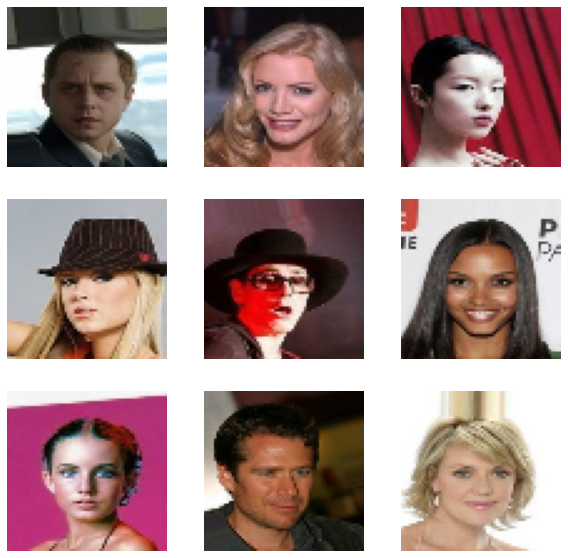

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images in dataset.take(1): # Take out one batch of 32 image in memory
  for i in range(9): # Plot first 9 from 32 images
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy())
    plt.axis("off")

## Create the Discriminator

We first create the discriminator. It is a typical image classifier. It is used to distinguish the real images from the images created by the generator. The discriminator has the following layers

+ Three pairs of Conv2D and LeakyReLU
+ Flatten it to convert 4D to 2D
+ Top layer with one neuron with sigmoid to produce the probability.



In [6]:
discriminator = keras.Sequential(
    [
        keras.Input(shape=(64, 64, 3)),
        layers.Conv2D(64, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Flatten(),
        layers.Dropout(0.2),
        layers.Dense(1, activation="sigmoid"),
    ],
    name="discriminator",
)


Let's summarize the network architecture of the discriminator.

In [7]:
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 64)        3136      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 128)       131200    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 128)         262272    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 8, 8, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 8192)            

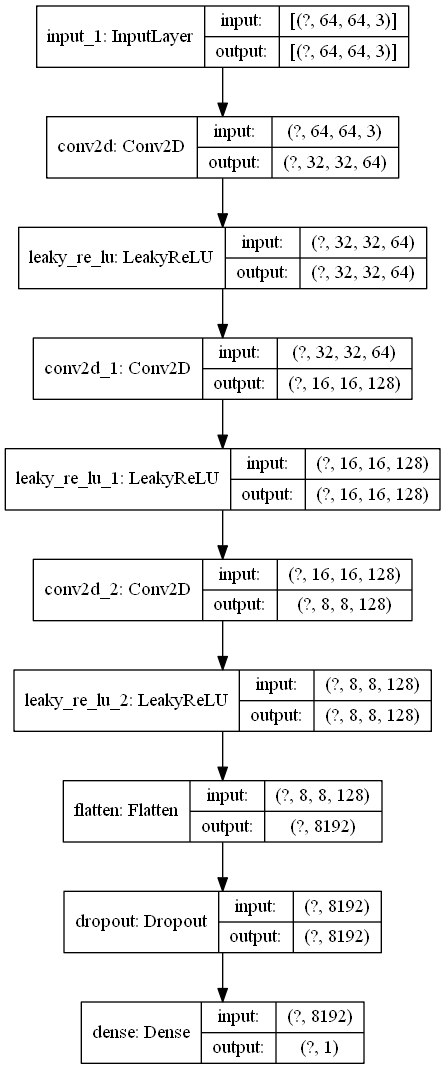

In [8]:
tf.keras.utils.plot_model(discriminator, show_shapes=True)

## Create the Generator

The generator helps create the fake images and pass them to the discriminator and get feedback from it.
We take advantage of Conv2DTranspose. Conv2DTranspose scales up the image by using the nearest neighbor or bilinear upsampling. It helps make the image larger and reconstruct the original image. 

The generator accepts a small size of 128 elements and scales it up using three layers of Conv2DTranspose. Finally, scale it down using regular Conv2D and get the exact size of the discriminator's image. 


In [9]:
latent_dim = 128

generator = keras.Sequential(
    [
        keras.Input(shape=(latent_dim,)),
        layers.Dense(8 * 8 * 128),
        layers.Reshape((8, 8, 128)),
        layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(256, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(512, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(3, kernel_size=5, padding="same", activation="sigmoid"),
    ],
    name="generator",
)


Let's summarize the network architecture of the generator.

In [10]:
generator.summary()

Model: "generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 8192)              1056768   
_________________________________________________________________
reshape (Reshape)            (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 16, 16, 128)       262272    
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 32, 32, 256)       524544    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 32, 32, 256)       0         
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 64, 64, 512)       20

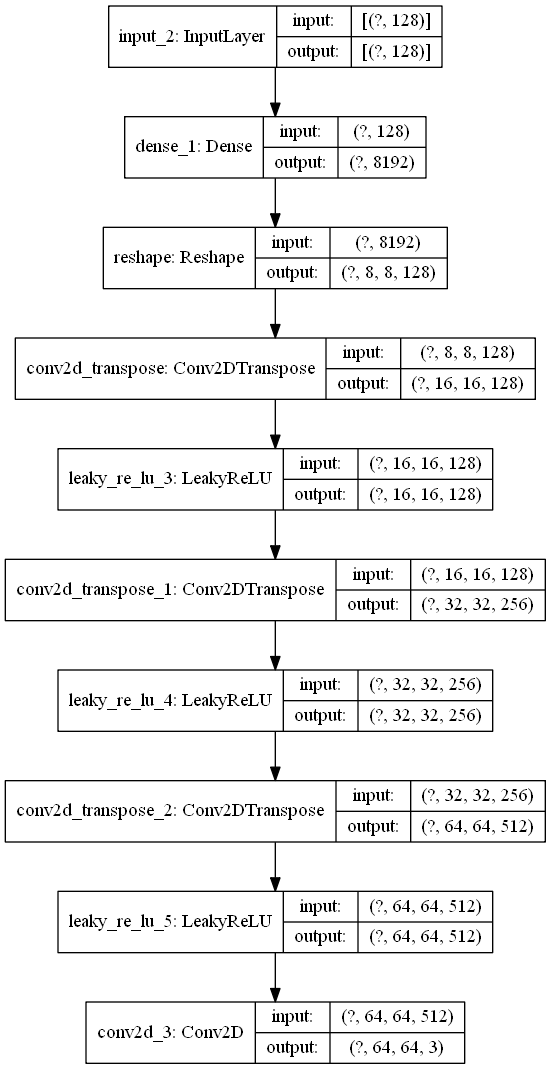

In [11]:
tf.keras.utils.plot_model(generator, show_shapes=True)

## Create the GAN Model

We derivate the GAN class from the parent class of Keras.Model.
+ Override the constructor of **init**, which initialize the discriminator, generator, and latent dimension
+ Override the compile method, configuring the optimizers, loss functions, and loss_metrics for the discriminator and generator, respectively.
+ Define the metrics method and add the @property decorator before the definition. Then metrics can be accessed as an attribute instead of a method with a () such as metrics().

We also Customizeg what happens in fit() method by overriding train_step() method (see: https://keras.io/guides/customizing_what_happens_in_fit/). This is the function that is called fit() for every batch of data. 


In [12]:
class GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(GAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):
        # Sample random points in the latent space
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Decode them to fake images
        generated_images = self.generator(random_latent_vectors)

        # Combine them with real images
        combined_images = tf.concat([generated_images, real_images], axis=0)

        # Assemble labels discriminating real from fake images
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
        )
        # Add random noise to the labels - important trick!
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        # Train the discriminator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # Sample random points in the latent space
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Assemble labels that say "all real images"
        misleading_labels = tf.zeros((batch_size, 1))

        # Train the generator (note that we should *not* update the weights
        # of the discriminator)!
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Update metrics
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {
            "d_loss": self.d_loss_metric.result(),
            "g_loss": self.g_loss_metric.result(),
        }

## Create a Callback to Save Generated Images

We write our own callback (Please see https://keras.io/guides/writing_your_own_callbacks/). At the end of an epoch during training, the engine will call on_epoch_end() method. We override this method to save generated images periodically.

In [13]:
class GANMonitor(keras.callbacks.Callback):
    # Initialize the number of images to save and the latent dimensionality
    def __init__(self, num_img=3, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim
   # Save the generated images at the end of an epoch
    def on_epoch_end(self, epoch, logs=None):
        # 
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        # Generate the image
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        for i in range(self.num_img):
            # Converts a 3D Numpy array to a PIL Image instance.
            img = keras.preprocessing.image.array_to_img(generated_images[i])
            # Save the image
            img.save("generated_img_%03d_%d.png" % (epoch, i))

In [14]:
%%time
epochs = 1  # In practice, use ~100 epochs

gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss_fn=keras.losses.BinaryCrossentropy(),
)

gan.fit(
    dataset, epochs=epochs, callbacks=[GANMonitor(num_img=10, latent_dim=latent_dim)]
)


6332/6332 [==============================] - 38207s 6s/step - d_loss: 0.6075 - g_loss: 1.2343
Wall time: 10h 36min 54s


6332/6332 [==============================] - 39293s 6s/step - d_loss: 0.6075 - g_loss: 1.2343

Wall time: 10h 55min 1s

## Visulize Generated Images

(Image size  = (64, 64, 3)


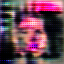

(Image size  = (64, 64, 3)


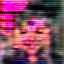

(Image size  = (64, 64, 3)


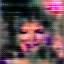

(Image size  = (64, 64, 3)


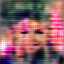

(Image size  = (64, 64, 3)


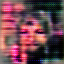

(Image size  = (64, 64, 3)


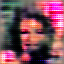

(Image size  = (64, 64, 3)


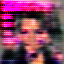

(Image size  = (64, 64, 3)


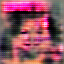

(Image size  = (64, 64, 3)


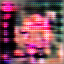

In [15]:
import glob
import PIL
from IPython.display import display # to display images

# Filter out the generate images from the current working directory
generate_imgage_files =glob.glob('generated_img_[0-9]*_[0-9].png')

# Plot the latest 9 images
for file in generate_imgage_files[-9:]:
    img = PIL.Image.open(str(file))
    #image mode means the number of channels , each image is #D (H,W, C)
    print(f'(Image size  = ({img.size[0]}, {img.size[0]}, {len(img.mode)})')
    display(img)

# Summary

+ Generative adversarial networks (GANs) composes of two deep networks, the generator, and the discriminator.
+ The generator generates the image as much closer to the true image as possible to fool the discriminator.
+ The discriminator tries to distinguish the generated images from the true images.
+ The train_step() method is used to customize the training procedure.
+ The callback class can be used to save data/images at the end of each epoch.
